## 1. Importação das bibliotecas e leitura do arquivo processado

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
import warnings
warnings.filterwarnings('ignore')

In [69]:
df_ml = pd.read_csv('coffee_sales_processed.csv')
df_ml.sample(5)

,hour_of_day,cash_type,money,coffee_name,Time_of_Day,Weekday,Month_name,Weekdaysort,Monthsort,Date,Time
2392,9,card,25.96,Cortado,Morning,Thu,Dec,4,12,2024-12-05,0 days 09:20:28.835000
715,10,card,27.92,Cortado,Morning,Mon,Jun,1,6,2024-06-17,0 days 10:12:05.139000
1747,12,card,25.96,Americano,Afternoon,Tue,Oct,2,10,2024-10-08,0 days 12:49:04.581000
743,18,card,37.72,Latte,Night,Thu,Jun,4,6,2024-06-20,0 days 18:59:02.082000
1383,20,card,32.82,Latte,Night,Fri,Sep,5,9,2024-09-06,0 days 20:00:12.025000


In [70]:
df_ml['Date'] = pd.to_datetime(df_ml['Date'], format='%Y-%m-%d')
df_ml['Time'] = pd.to_timedelta(df_ml['Time'])

## 2. Criação do Modelo e Análise de Acurácia


Formato dos dados: (3547, 11)

Features: (3547, 10)
Target: (3547,)

Treino: (2837, 10), Teste: (710, 10)
RMSE: 0.71
MAE: 0.27


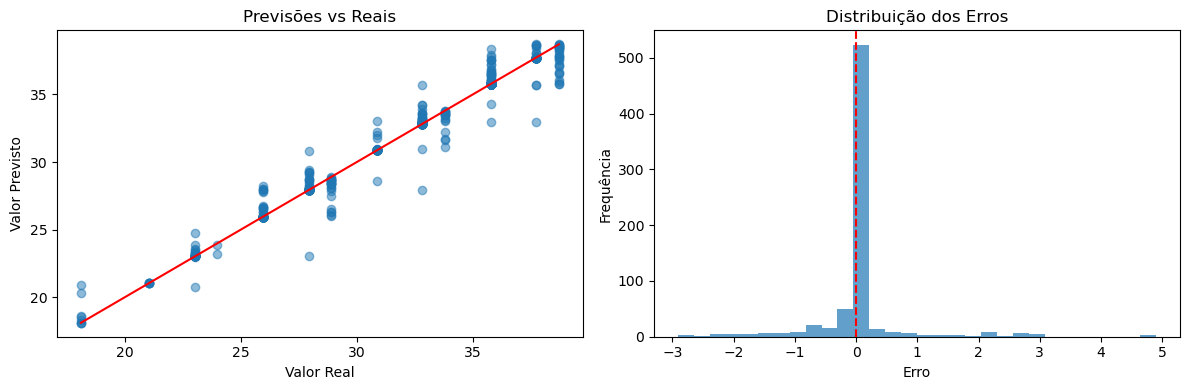

In [71]:
print(f"\nFormato dos dados: {df_ml.shape}")

X = df_ml.drop('money', axis=1)
y = df_ml['money']

print(f"\nFeatures: {X.shape}")
print(f"Target: {y.shape}")

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"\nTreino: {X_train.shape}, Teste: {X_test.shape}")

numeric_features = ['hour_of_day', 'Weekdaysort', 'Monthsort']
categorical_features = ['cash_type', 'coffee_name', 'Time_of_Day', 'Weekday', 'Month_name']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features)
    ])

modelo = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))
])

modelo.fit(X_train, y_train)

y_pred = modelo.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'red')
plt.xlabel('Valor Real')
plt.ylabel('Valor Previsto')
plt.title('Previsões vs Reais')

plt.subplot(1, 2, 2)
erros = y_test - y_pred
plt.hist(erros, bins=30, alpha=0.7)
plt.axvline(x=0, color='red', linestyle='--')
plt.xlabel('Erro')
plt.ylabel('Frequência')
plt.title('Distribuição dos Erros')

plt.tight_layout()
plt.show()

## 3. Sugestão de Promoção de Cafés

In [72]:
cafes = df_ml['coffee_name'].unique()
dias = df_ml['Weekday'].unique()
horarios = df_ml['hour_of_day'].unique()

resultados = []

for cafe in cafes:
    df_cafe = df_ml[df_ml['coffee_name'] == cafe]
    
    if df_cafe.empty:
        continue
    
    cash_type_mais_comum = df_cafe['cash_type'].mode()[0]
    time_of_day_mais_comum = df_cafe['Time_of_Day'].mode()[0]
    weekday_mais_comum = df_cafe['Weekday'].mode()[0]
    weekdaysort_mais_comum = df_cafe['Weekdaysort'].mode()[0]
    
    predicoes_horario = []
    for hora in horarios:
        time_of_day = 'morning' if hora < 12 else 'afternoon'
        
        dados_entrada = pd.DataFrame({
            'hour_of_day': [hora],
            'cash_type': [cash_type_mais_comum],
            'coffee_name': [cafe],
            'Time_of_Day': [time_of_day],
            'Weekday': [weekday_mais_comum],
            'Month_name': ['January'],
            'Weekdaysort': [weekdaysort_mais_comum],
            'Monthsort': [1]
        })
        
        predicao = modelo.predict(dados_entrada)[0]
        predicoes_horario.append((hora, predicao))
    
    melhor_hora = max(predicoes_horario, key=lambda x: x[1])[0]
    
    predicoes_dia = []
    for dia in dias:
        weekdaysort = df_ml[df_ml['Weekday'] == dia]['Weekdaysort'].iloc[0]
        
        dados_entrada = pd.DataFrame({
            'hour_of_day': [df_cafe['hour_of_day'].median()],
            'cash_type': [cash_type_mais_comum],
            'coffee_name': [cafe],
            'Time_of_Day': [time_of_day_mais_comum],
            'Weekday': [dia],
            'Month_name': ['January'],
            'Weekdaysort': [weekdaysort],
            'Monthsort': [1]
        })
        
        predicao = modelo.predict(dados_entrada)[0]
        predicoes_dia.append((dia, predicao))
    
    melhor_dia = max(predicoes_dia, key=lambda x: x[1])[0]
    
    resultados.append({
        'cafe': cafe,
        'melhor_horario': melhor_hora,
        'melhor_dia': melhor_dia
    })

df_promocoes = pd.DataFrame(resultados)

Com base na análise preditiva, os melhores momentos para promover cada tipo de café são:

- Latte, Hot Chocolate, Americano, Cocoa, Cortado e Cappuccino: Sexta-feira às 10h

- Americano com Leite e Espresso: Segunda-feira às 10h

Esta estratégia aproveita os horários de maior demanda prevista para maximizar o impacto das promoções.